In [1]:
using Revise
using DifferentialEquations
using Thyrosim
using DiffEqCallbacks
using DiffEqParamEstim
using SharedArrays
using Plots
using Optim
using Statistics

┌ Info: Precompiling DiffEqParamEstim [1130ab10-4a5a-5621-a13d-e4788d82bd4c]
└ @ Base loading.jl:1273


# Import data

In [2]:
#schneider data
train, test, toy = schneider_data();

#blakesley data & tspan
my_time, my400_data, my450_data, my600_data = blakesley_data()
blakesley_tspan = (my_time[1], my_time[end])

#jonklaas data & tspan
patient_param, patient_dose, patient_t4, patient_t3, patient_tsh = jonklaas_data()
jonklaas_tspan = (0.0, 8.0)

(0.0, 8.0)

# Helper functions needed for simulations

In [3]:
# gives 400 mcg of oral T4 at hour 24
function blakesley_condition(u, t, integrator)
    return t - 24.0
end

# gives T3 dose at hour 0
function jonklaas_condition(u, t, integrator)
    return t - 0.01 #cannot make this exactly 0
end

# define function for adding dose
function add_dose!(integrator)
    integrator.u[10] += integrator.p[55]
    integrator.u[12] += integrator.p[56]
end

function compute_euthyroid_dose_error(sol)
    tot_loss = 0
    if any((s.retcode != :Success for s in sol))
        tot_loss = Inf
    else
        total_hours  = sol.t[end]
        TSH_last_day = sol.u[sol.t .>= total_hours - 24]
        if !Base.all(0.5 .≤ TSH_last_day .≤ 4.5)
            tot_loss += 1
        end
    end
    return tot_loss
end
  
function compute_initial_dose_error(sol)
    tot_loss = 0
    if any((s.retcode != :Success for s in sol))
        tot_loss = Inf
    else
        total_hours  = sol.t[end]
        TSH_last_day = sol.u[sol.t .>= total_hours - 24]
        if Base.all(0.5 .≤ TSH_last_day .≤ 4.5)
            tot_loss += 1
        end
    end
    return tot_loss
end
                      
# distance to set penalty where the set C = [0.5, 4.5]
function compute_euthyroid_dose_l2_error(sol)
    tot_loss = 0.0
    if any((s.retcode != :Success for s in sol))
        tot_loss = Inf
    else
        tsh = sol.u[end]
        if tsh > 4.5
            tot_loss += (tsh - 4.5)^2
        elseif tsh < 0.5
            tot_loss += (0.5 - tsh)^2
        end
    end
    return tot_loss
end
                                    
# distance to set penalty where the set C = [0.0, 0.5] ∪ [4.5, Inf]                       
function compute_initial_dose_l2_error(sol, euthyroid_dose, initial_dose)
    tot_loss = 0
    if any((s.retcode != :Success for s in sol))
        tot_loss = Inf
    else
        tsh = sol.u[end]
        if euthyroid_dose > initial_dose && tsh < 4.5 #original TSH too high
            tot_loss += (4.5 - tsh)^2
        elseif euthyroid_dose < initial_dose && tsh > 0.5 #original TSH too low
            tot_loss += (0.5 - tsh)^2
        end
    end
    return tot_loss
end
                     
function blakesley_tsh_error(sol, time, data, Vtsh)
    tot_loss = 0.0
    if any((s.retcode != :Success for s in sol))
        tot_loss = Inf
    else
        for i in 1:length(time)
            predicted_tsh = sol(time[i])[2] * 5.6 / Vtsh
            tot_loss += (predicted_tsh - data[i, 3])^2
        end
    end
    return tot_loss
end
            
function blakesley_t4_error(sol, time, data, Vp)
    tot_loss = 0.0
    if any((s.retcode != :Success for s in sol))
        tot_loss = Inf
    else
        for i in 1:length(time)
            T4_predicted = sol(time[i])[1] * 777.0 / Vp
            tot_loss += (T4_predicted - data[i, 1])^2
        end
    end
    return tot_loss
end
                                                
function jonklaas_error(sol, time, data, Vp)
    tot_loss = 0.0
    if any((s.retcode != :Success for s in sol))
        tot_loss = Inf
    else
        for i in 1:length(time)
            T3_predicted = sol(time[i]) * 651.0 / Vp
            tot_loss += (T3_predicted - data[i])^2
        end
    end
    return tot_loss
end

jonklaas_error (generic function with 1 method)

# Result

In [26]:
fitting_index = SharedArray{Int}([28; 45; 30; 31; 49; 50; 51; 52; 53; 54])
initial_guess = [ 0.8892067744277633;1.6882221360501146;69.90379778202167;38.71161774205076;  
                  6.039888256864343; 3.7006563259936747;8.748185980217668;6.590694001313398; 
                  2.896554559451672;13.013203952637502]
train_minimizer = [0.6039222046641435, 22.087463157341936, 103.36585765448072, 
            89.55523275731187, 67.93860849674263, 3.646391720870975, 0.0400965033683874, 
            7.134927653438794, 5.973788223841496, 23.971174120935313]

10-element Array{Float64,1}:
   0.6039222046641435
  22.087463157341936 
 103.36585765448072  
  89.55523275731187  
  67.93860849674263  
   3.646391720870975 
   0.0400965033683874
   7.134927653438794 
   5.973788223841496 
  23.971174120935313 

## Blakesley data (T4 and TSH data)

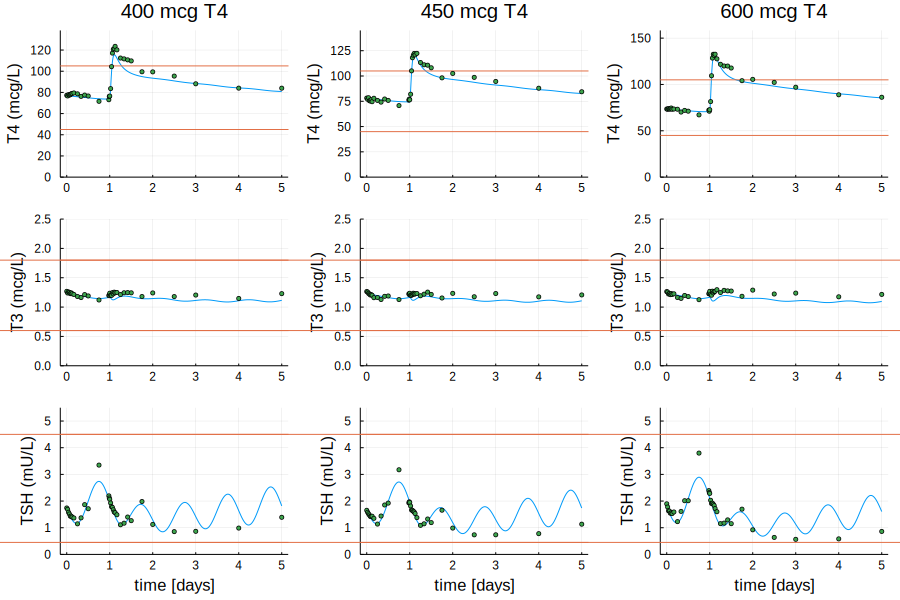

In [79]:
cbk   = ContinuousCallback(blakesley_condition, add_dose!); 
ic, p = initialize([1.0; 0.88; 1.0; 0.88]) 
p[fitting_index] = train_minimizer

#400 T4
T4_init_400, T3_init_400, TSH_init_400 = my400_data[1, :]
set_patient_ic!(ic, p, T4_init_400, T3_init_400, TSH_init_400, steady_state=true, set_tsh_lag=true)
p[55] = 400 / 777.0
p[56] = 0.0
prob400 = ODEProblem(thyrosim,ic,(0.0, 120.0),p,callback=cbk)
sol400 = solve(prob400)
a = plot_blakesley(sol400, "400", title="400 mcg T4")

# 450 T4
T4_init_450, T3_init_450, TSH_init_450 = my450_data[1, :]
set_patient_ic!(ic, p, T4_init_450, T3_init_450, TSH_init_450, steady_state=true, set_tsh_lag=true)
p[55] = 450 / 777.0
prob450 = ODEProblem(thyrosim,ic,(0.0, 120.0),p,callback=cbk)
sol450 = solve(prob450)
b = plot_blakesley(sol450, "450", title="450 mcg T4")

#600 T4
T4_init_600, T3_init_600, TSH_init_600 = my600_data[1, :]
set_patient_ic!(ic, p, T4_init_600, T3_init_600, TSH_init_600, steady_state=true, set_tsh_lag=true)
p[55] = 600 / 777.0
prob600 = ODEProblem(thyrosim,ic,(0.0, 120.0),p,callback=cbk)
sol600 = solve(prob600)
c = plot_blakesley(sol600, "600", title="600 mcg T4")

blakesley_plot = plot(a, b, c, layout=(1, 3), size=(900, 600))

In [32]:
savefig(blakesley_plot, "blakesley_plot.svg")

## Jonklaas data (T3 data)
overweight patients are those with BMI > 30.

In [145]:
jonklaas_times_simulation = collect(0.0:0.1:8.0)
jonklaas_times_realdata = [0.0; 0.5; 1.0; 2.0; 3.0; 4.0; 5.0; 6.0; 7.0; 8.0] # same time invervals as data
points = length(jonklaas_times)
normal_45_T4  = [Float64[] for i in 1:points]     # 3 patients
normal_45_T3  = [Float64[] for i in 1:points]     # 3 patients
normal_45_TSH = [Float64[] for i in 1:points]     # 3 patients
normal_30_T4  = [Float64[] for i in 1:points]     # 6 patients
normal_30_T3  = [Float64[] for i in 1:points]     # 6 patients
normal_30_TSH = [Float64[] for i in 1:points]     # 6 patients
overweight_45_T4  = [Float64[] for i in 1:points] # 4 patients
overweight_45_T3  = [Float64[] for i in 1:points] # 4 patients
overweight_45_TSH = [Float64[] for i in 1:points] # 4 patients
overweight_30_T4  = [Float64[] for i in 1:points] # 2 patients
overweight_30_T3  = [Float64[] for i in 1:points] # 2 patients
overweight_30_TSH = [Float64[] for i in 1:points] # 2 patients

for i in 1:15
    height, weight, sex = patient_param[i, :]
    T4init, T3init, TSHinit = patient_t4[i, 1], patient_t3[i, 1], patient_tsh[i, 1]
    T3dose = patient_dose[i]
    ic, p = initialize([0.0; 0.88; 0.0; 0.88], true, height, weight, Bool(sex)) 
    set_patient_ic!(ic, p, T4init, T3init, TSHinit, steady_state=true, set_tsh_lag=true)
    p[55] = 0.0
    p[56] = T3dose / 651.0
    cbk   = ContinuousCallback(jonklaas_condition, add_dose!); 
    p[fitting_index] = train_minimizer
    prob = ODEProblem(thyrosim,ic,(0.0, 8.0),p,callback=cbk)
    sol = solve(prob)
    
    BMI = weight / height^2
    if BMI < 30
        # normal patient
        if T3dose == 30
            for (i, t) in enumerate(jonklaas_times_simulation)
                push!(normal_30_T4[i], sol(t)[1] * 777.0 / p[47])
                push!(normal_30_T3[i], sol(t)[4] * 651.0 / p[47])
                push!(normal_30_TSH[i], sol(t)[7] * 5.2 / p[48])
            end
        else
            for (i, t) in enumerate(jonklaas_times_simulation)
                push!(normal_45_T4[i], sol(t)[1] * 777.0 / p[47])
                push!(normal_45_T3[i], sol(t)[4] * 651.0 / p[47])
                push!(normal_45_TSH[i], sol(t)[7] * 5.2 / p[48])
            end
        end
    else
        # overweight patient
        if T3dose == 30
            for (i, t) in enumerate(jonklaas_times_simulation)
                push!(overweight_30_T4[i], sol(t)[1] * 777.0 / p[47])
                push!(overweight_30_T3[i], sol(t)[4] * 651.0 / p[47])
                push!(overweight_30_TSH[i], sol(t)[7] * 5.2 / p[48])
            end
        else
            for (i, t) in enumerate(jonklaas_times_simulation)
                push!(overweight_45_T4[i], sol(t)[1] * 777.0 / p[47])
                push!(overweight_45_T3[i], sol(t)[4] * 651.0 / p[47])
                push!(overweight_45_TSH[i], sol(t)[7] * 5.2 / p[48])
            end
        end
    end
end

In [141]:
normal_45_T3

81-element Array{Array{Float64,1},1}:
 [0.596, 0.866, 0.746]                                       
 [0.8505839467403825, 1.140794989911046, 1.0186965912127417] 
 [1.1631298055748092, 1.4762515029858505, 1.3528423046721256]
 [1.3873806105470634, 1.7154552561210556, 1.5919794730153476]
 [1.5652880908025275, 1.9049143558524049, 1.7815553714824794]
 [1.7170228632070104, 2.066425304679859, 1.9432002601708078] 
 [1.8496161803732731, 2.207459526767373, 2.0844038203795456] 
 [1.9659465383992736, 2.3310577692653722, 2.2082247428538597]
 [2.0677020800121664, 2.4390159641972784, 2.31646200096858]  
 [2.156201558849739, 2.5327465293940894, 2.410524605438517]  
 [2.2325905639814065, 2.6134823822419926, 2.491638913202455] 
 [2.2979250146444197, 2.682358974650832, 2.5609348777912273] 
 [2.353167006919601, 2.7404166054188615, 2.6194451763597364] 
 ⋮                                                           
 [1.3863186195201247, 1.6709670948417885, 1.5704011082283555]
 [1.36922890119238, 1.6525156132

In [142]:
# compute averages
normal_45_T4_mean = mean.(normal_45_T4)      # 3 patients
normal_45_T3_mean = mean.(normal_45_T3)      # 3 patients
normal_45_TSH_mean = mean.(normal_45_TSH)     # 3 patients
normal_30_T4_mean = mean.(normal_30_T4)      # 6 patients
normal_30_T3_mean = mean.(normal_30_T3)      # 6 patients
normal_30_TSH_mean = mean.(normal_30_TSH)     # 6 patients
overweight_45_T4_mean = mean.(overweight_45_T4)  # 4 patients
overweight_45_T3_mean = mean.(overweight_45_T3)  # 4 patients
overweight_45_TSH_mean = mean.(overweight_45_TSH) # 4 patients
overweight_30_T4_mean = mean.(overweight_30_T4)  # 2 patients
overweight_30_T3_mean = mean.(overweight_30_T3)  # 2 patients
overweight_30_TSH_mean = mean.(overweight_30_TSH) # 2 patients

[normal_45_T3_mean normal_30_T3_mean overweight_45_T3_mean overweight_30_T3_mean]

81×4 Array{Float64,2}:
 0.736    1.11117  0.91375  0.9415 
 1.00336  1.29873  1.19548  1.10454
 1.33074  1.52384  1.54479  1.30495
 1.56494  1.68176  1.79514  1.44689
 1.75059  1.80639  1.99336  1.5589 
 1.90888  1.91255  2.16213  1.65414
 2.04716  2.00507  2.30937  1.7371 
 2.16841  2.08591  2.43832  1.80957
 2.27439  2.15626  2.55088  1.87263
 2.36649  2.21705  2.64854  1.92713
 2.4459   2.26912  2.7326   1.97383
 2.51374  2.31325  2.80424  2.0134 
 2.57101  2.35012  2.86455  2.04648
 ⋮                                 
 1.54256  1.58035  1.71146  1.34238
 1.5246   1.56784  1.6916   1.3308 
 1.50715  1.55564  1.67229  1.31951
 1.49014  1.54379  1.65346  1.30854
 1.4736   1.53227  1.63515  1.29786
 1.45753  1.52104  1.61734  1.28745
 1.44187  1.51015  1.59998  1.27734
 1.42667  1.49955  1.58312  1.2675 
 1.41189  1.48924  1.56671  1.25793
 1.3975   1.47925  1.55074  1.24863
 1.38354  1.46951  1.53523  1.23957
 1.36995  1.46006  1.52013  1.23077

In [143]:
# compute sample standard deviations
normal_45_T4_std = std.(normal_45_T4)      # 3 patients
normal_45_T3_std = std.(normal_45_T3)      # 3 patients
normal_45_TSH_std = std.(normal_45_TSH)     # 3 patients
normal_30_T4_std = std.(normal_30_T4)      # 6 patients
normal_30_T3_std = std.(normal_30_T3)      # 6 patients
normal_30_TSH_std = std.(normal_30_TSH)     # 6 patients
overweight_45_T4_std = std.(overweight_45_T4)  # 4 patients
overweight_45_T3_std = std.(overweight_45_T3)  # 4 patients
overweight_45_TSH_std = std.(overweight_45_TSH) # 4 patients
overweight_30_T4_std = std.(overweight_30_T4)  # 2 patients
overweight_30_T3_std = std.(overweight_30_T3)  # 2 patients
overweight_30_TSH_std = std.(overweight_30_TSH) # 2 patients

[normal_45_T3_std normal_30_T3_std overweight_45_T3_std overweight_30_T3_std]

81×4 Array{Float64,2}:
 0.135277  0.477583  0.117896   0.1393    
 0.145712  0.46159   0.059096   0.114069  
 0.157726  0.444945  0.0395569  0.0849718 
 0.165701  0.431762  0.0864032  0.0636238 
 0.171918  0.421025  0.128861   0.04638   
 0.177211  0.411796  0.166042   0.0314682 
 0.181806  0.403616  0.198966   0.0182584 
 0.185783  0.396264  0.228148   0.00649351
 0.189198  0.389607  0.253919   0.00397914
 0.192096  0.383553  0.276562   0.0132706 
 0.194521  0.37802   0.296328   0.0214832 
 0.196514  0.372956  0.313459   0.0286986 
 0.198116  0.368277  0.328167   0.0350248 
 ⋮                                        
 0.144352  0.298288  0.146792   0.00212949
 0.143626  0.298116  0.143121   0.00320575
 0.142922  0.297946  0.139571   0.00424578
 0.142235  0.297798  0.136118   0.00527878
 0.14157   0.297625  0.132749   0.00624723
 0.140924  0.297471  0.1295     0.00720493
 0.140295  0.297324  0.126326   0.00813898
 0.139687  0.297151  0.123245   0.00901212
 0.139095  0.297005  0.120273  

## Now add data

In [146]:
normal_45_T4_data  = zeros(10, 3)     # 3 patients
normal_45_T3_data  = zeros(10, 3)     # 3 patients
normal_45_TSH_data = zeros(10, 3)     # 3 patients
normal_30_T4_data  = zeros(10, 6)     # 6 patients
normal_30_T3_data  = zeros(10, 6)     # 6 patients
normal_30_TSH_data = zeros(10, 6)     # 6 patients
overweight_45_T4_data  = zeros(10, 4) # 4 patients
overweight_45_T3_data  = zeros(10, 4) # 4 patients
overweight_45_TSH_data = zeros(10, 4) # 4 patients
overweight_30_T4_data  = zeros(10, 2) # 2 patients
overweight_30_T3_data  = zeros(10, 2) # 2 patients
overweight_30_TSH_data = zeros(10, 2) # 2 patients

normal_45_counter = 1
normal_30_counter = 1
overweight_45_counter = 1
overweight_30_counter = 1
for i in 1:15
    height, weight, sex = patient_param[i, :]
    BMI = weight / height^2
    T3dose = patient_dose[i]
    
    if BMI < 30
        # normal patient
        if T3dose == 30
            normal_30_T4_data[:, normal_30_counter] .= patient_t4[i, :]
            normal_30_T3_data[:, normal_30_counter] .= patient_t3[i, :]
            normal_30_TSH_data[:, normal_30_counter] .= patient_tsh[i, :]
            normal_30_counter += 1
        else
            normal_45_T4_data[:, normal_45_counter] .= patient_t4[i, :]
            normal_45_T3_data[:, normal_45_counter] .= patient_t3[i, :]
            normal_45_TSH_data[:, normal_45_counter] .= patient_tsh[i, :]
            normal_45_counter += 1
        end
    else
        # overweight patient
        if T3dose == 30
            overweight_30_T4_data[:, overweight_30_counter] .= patient_t4[i, :]
            overweight_30_T3_data[:, overweight_30_counter] .= patient_t3[i, :]
            overweight_30_TSH_data[:, overweight_30_counter] .= patient_tsh[i, :]
            overweight_30_counter += 1
        else
            overweight_45_T4_data[:, overweight_45_counter] .= patient_t4[i, :]
            overweight_45_T3_data[:, overweight_45_counter] .= patient_t3[i, :]
            overweight_45_TSH_data[:, overweight_45_counter] .= patient_tsh[i, :]
            overweight_45_counter += 1
        end
    end
end

In [147]:
normal_45_T3_data

10×3 Array{Float64,2}:
 0.596  0.866  0.746
 0.938  1.088  0.895
 1.234  2.614  1.636
 1.735  3.631  3.471
 1.539  3.024  3.34 
 1.578  2.476  3.053
 1.65   2.425  2.636
 1.391  2.048  1.81 
 1.273  2.011  1.804
 1.163  1.705  1.687

In [148]:
# mean and std of data
normal_45_T3_data_mean = mean(normal_45_T3_data, dims=2)
normal_30_T3_data_mean = mean(normal_30_T3_data, dims=2)
overweight_45_T3_data_mean = mean(overweight_45_T3_data, dims=2)
overweight_30_T3_data_mean = mean(overweight_30_T3_data, dims=2)
normal_45_T3_data_std = std(normal_45_T3_data, dims=2)
normal_30_T3_data_std = std(normal_30_T3_data, dims=2)
overweight_45_T3_data_std = std(overweight_45_T3_data, dims=2)
overweight_30_T3_data_std = std(overweight_30_T3_data, dims=2)

10×1 Array{Float64,2}:
 0.1393000358937499  
 0.3726452736853107  
 0.09899494936611673 
 0.16829141392239846 
 0.034648232278140935
 0.07283199846221439 
 0.2156675682618971  
 0.08838834764831845 
 0.0106066017177983  
 0.18596908345206178 

# Make 4 plots

In [157]:
Plots.scalefontsizes(1.5)

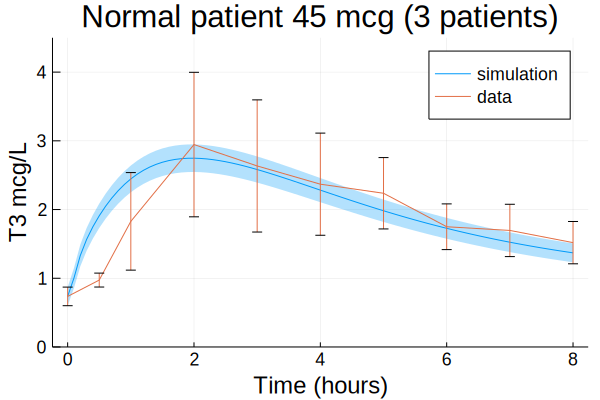

In [158]:
# plot simulation
normal_45_graph = plot(jonklaas_times_simulation, normal_45_T3_mean, ylabel="T3 mcg/L", xlabel="Time (hours)", ylim=(0, 4.5), 
    label="simulation", ribbon=normal_45_T3_std, fillalpha=.3, title="Normal patient 45 mcg (3 patients)")

# plot data
normal_45_graph = plot!(normal_45_graph, jonklaas_times_realdata, normal_45_T3_data_mean, ylabel="T3 mcg/L", xlabel="Time (hours)", ylim=(0, 4.5), 
    label="data", yerror=normal_45_T3_data_std)
display(normal_45_graph)

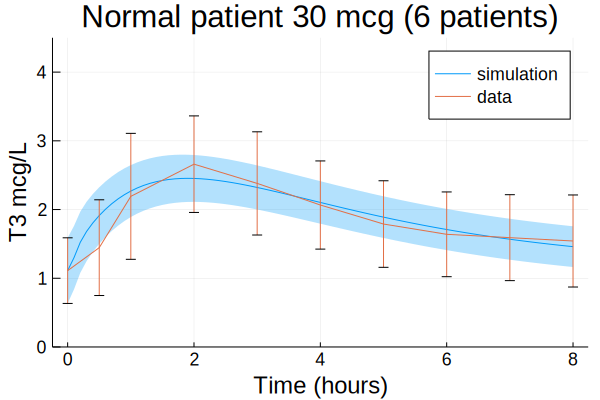

In [159]:
normal_30_graph = plot(jonklaas_times_simulation, normal_30_T3_mean, ylabel="T3 mcg/L", xlabel="Time (hours)", ylim=(0, 4.5), 
    label="simulation", ribbon=normal_30_T3_std, fillalpha=.3, title="Normal patient 30 mcg (6 patients)")
normal_30_graph = plot!(normal_30_graph, jonklaas_times_realdata, normal_30_T3_data_mean, ylabel="T3 mcg/L", xlabel="Time (hours)", ylim=(0, 4.5), 
    label="data", yerror=normal_30_T3_data_std)
display(normal_30_graph)

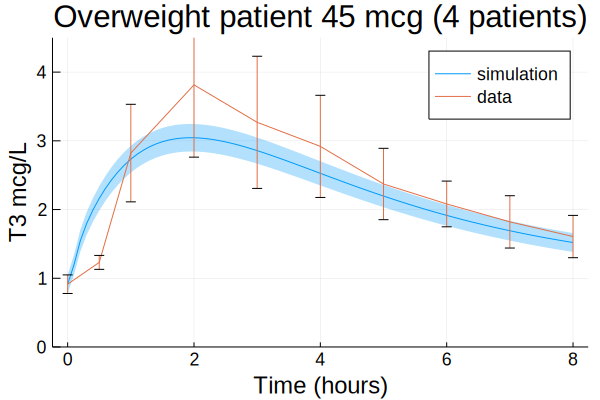

In [160]:
overweight_45_graph = plot(jonklaas_times_simulation, overweight_45_T3_mean, ylabel="T3 mcg/L", xlabel="Time (hours)", ylim=(0, 4.5), 
    label="simulation", ribbon=normal_45_T3_std, fillalpha=.3, title="Overweight patient 45 mcg (4 patients)")
overweight_45_graph = plot!(overweight_45_graph, jonklaas_times_realdata, overweight_45_T3_data_mean, ylabel="T3 mcg/L", xlabel="Time (hours)", ylim=(0, 4.5), 
    label="data", yerror=normal_45_T3_data_std)
display(overweight_45_graph)

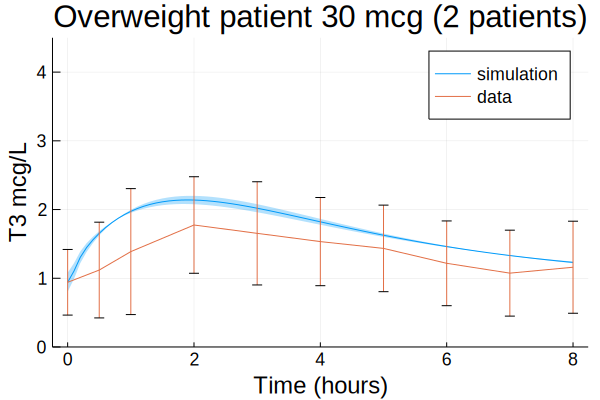

In [161]:
overweight_30_graph = plot(jonklaas_times_simulation, overweight_30_T3_mean, ylabel="T3 mcg/L", xlabel="Time (hours)", ylim=(0, 4.5), 
    label="simulation", ribbon=overweight_30_T3_std, fillalpha=.3, title="Overweight patient 30 mcg (2 patients)")
overweight_30_graph = plot!(overweight_30_graph, jonklaas_times_realdata, overweight_30_T3_data_mean, ylabel="T3 mcg/L", xlabel="Time (hours)", ylim=(0, 4.5), 
    label="data", yerror=normal_30_T3_data_std)
display(overweight_30_graph)

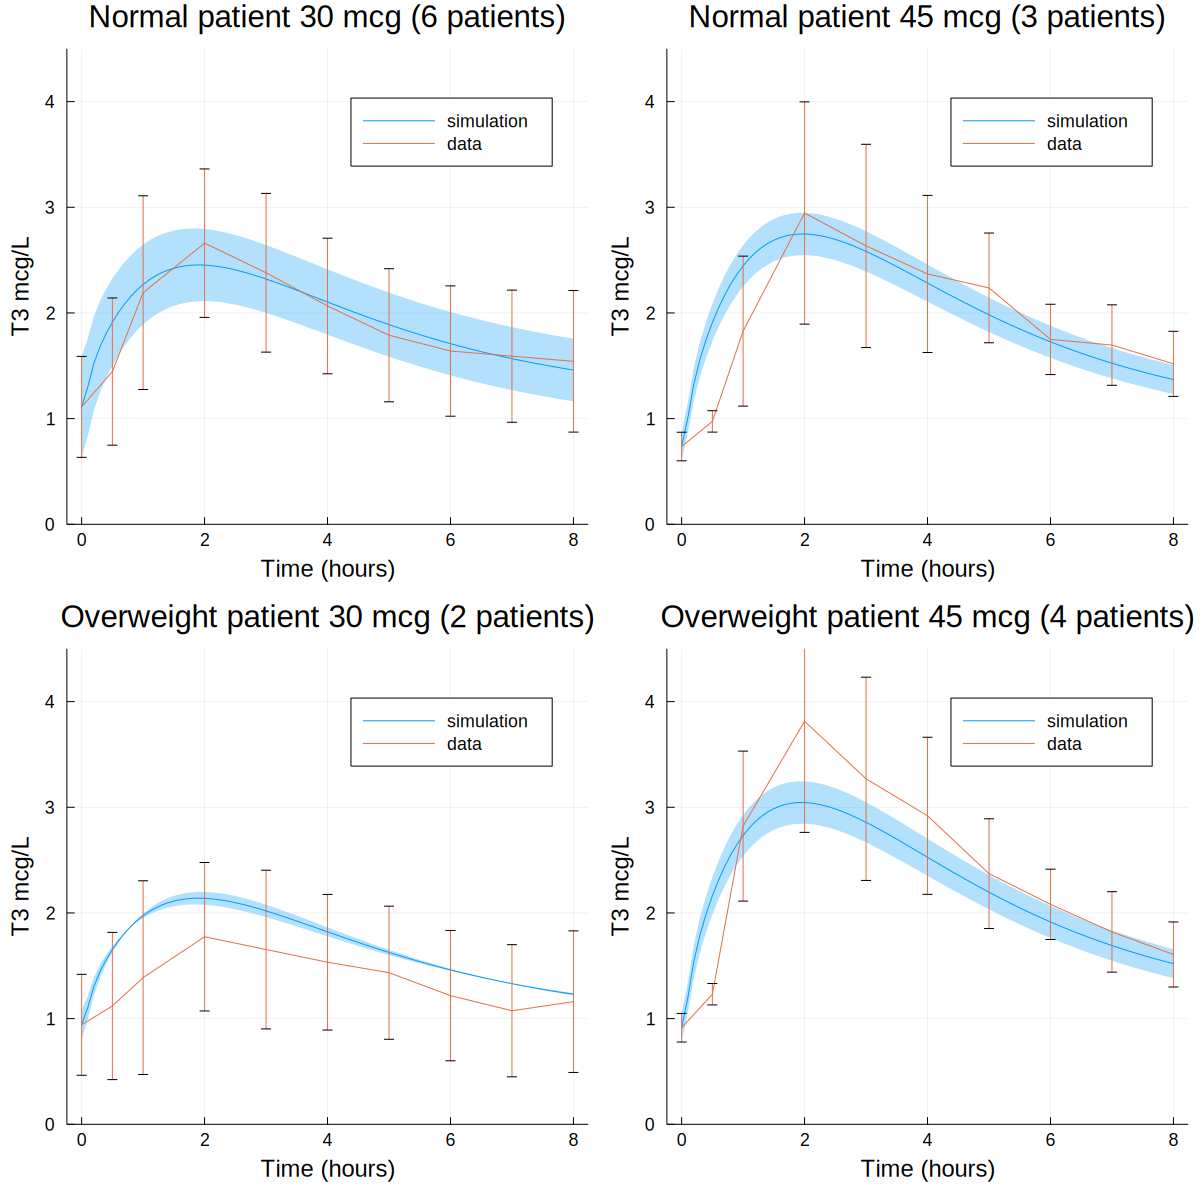

In [165]:
combine = plot(normal_30_graph, normal_45_graph, 
    overweight_30_graph, overweight_45_graph, 
    layout=(2, 2), size=(1200, 1200))

In [166]:
savefig(combine, "jonklaas_fig.svg")

# Schneider plots

For each patient, we test various T4 doses (in intervals of 12.5 mcg) to see if they normalize TSH values, then compare it to data.

In [113]:
train, test, toy = schneider_data()
all_schneider = [train; test]

,Surgeon,Race,Sex,Age,Wt.lb,Wt.kg,Ht.in,Ht.m,BMI,LT4.initial.dose
,String,Int64,Int64,Float64,Int64,Float64,Float64,Float64,Float64,Float64
1,3,1,0,60.1,254,115.2,71.5,1.8161,34.9279,175.0
2,1,1,1,65.0,170,77.1,68.0,1.7272,25.8446,125.0
3,2,1,1,61.4,113,51.3,62.0,1.5748,20.6855,100.0
4,1,1,1,66.4,103,46.7,61.0,1.5494,19.4531,88.0
5,2,1,0,64.4,224,101.6,68.0,1.7272,34.0572,175.0
6,1,1,1,63.2,227,103.0,62.0,1.5748,41.5323,150.0
7,1,1,1,59.0,167,75.7,64.0,1.6256,28.6463,112.0
8,1,1,1,50.3,203,92.1,65.0,1.651,33.7882,137.0
9,2,1,0,69.1,204,92.5,71.0,1.8034,28.4418,175.0


## Possible doses

We will test T4 doses from 62.5, 75 ... all the way to 325 mcg. The smallest dose that achieves euthyroidism (i.e. $0.5 <=$ TSH in last day $<= 4.5$) will be used as the **predicted dosage** on the basis of using the least amount of drugs possible. 

+ min/max weight = 38.1/206.4 KG 
+ using 1.6 of T4 per KG -> 61 ~ 330 mcg of T4
+ So test dosages = 62.5 ~ 325 with 12.5 as increments

In [99]:
# helper functions
function find_doses(
    height::Float64, 
    weight::Float64, 
    sex::Bool,
    tspan::Float64,
    cbk, # call back function
    p,   # parameter vector
    ic,  # initial condition 
    )
    
    possible_doses  = collect(62.5:12.5:325)
    predicted_doses = Float64[]
    
    for dose in possible_doses
        p[55] = dose / 777.0
        prob  = ODEProblem(thyrosim,ic,(0.0, tspan),p,callback=cbk)
        sol   = solve(prob, save_idxs=7)
        loss  = check_TSH_within_interval(sol)
        
        # save doses that work
        if loss == 0
            push!(predicted_doses, dose)
        end
    end
    
    return predicted_doses
end

# returns 1 if TSH not within interval
function check_TSH_within_interval(sol)
    tot_loss = 0
    total_hours  = sol.t[end]
    TSH_last_day = sol.u[sol.t .>= total_hours - 24]
    if !Base.all(0.5 .≤ TSH_last_day .≤ 4.5)
        tot_loss += 1
    end
    return tot_loss
end

check_TSH_within_interval (generic function with 1 method)

In [100]:
function find_all_doses(train_data)
    # parse data
    height = train_data[!, Symbol("Ht.m")]
    weight = train_data[!, Symbol("Wt.kg")]
    sex    = train_data[!, Symbol("Sex")]
    tspan  = 24train_data[!, Symbol("Days.to.euthyroid")]
    init_tsh = train_data[!, Symbol("TSH.preop")]
    
    # define vector of possible doses
    predicted_doses = Vector{Vector{Float64}}(undef, size(train_data, 1))
    
    # model setup
    cbk   = PeriodicCallback(add_dose!, 24.0)# function to add dose
    dial  = [0.0; 0.88; 0.0; 0.88]
    fitting_index = [28; 45; 30; 31; 49; 50; 51; 52; 53; 54]
    train_minimizer = [0.6039222046641435, 22.087463157341936, 103.36585765448072, 
            89.55523275731187, 67.93860849674263, 3.646391720870975, 0.0400965033683874, 
            7.134927653438794, 5.973788223841496, 23.971174120935313]
    scale_Vp = true
    
    # loop over each patient
    for i in 1:size(train_data, 1)
        w     = weight[i]
        h     = height[i]
        s     = Bool(sex[i])
        t     = Float64(tspan[i])
        ic, p = initialize(dial, scale_Vp, h, w, s)
        p[fitting_index] = train_minimizer
        ic[7] = init_tsh[i]
        
        # find dose
        predicted_doses[i] = find_doses(h, w, s, t, cbk, p, ic)
    end
    
    return predicted_doses
end

find_min_doses (generic function with 2 methods)

In [101]:
result = find_all_doses(all_schneider) # seems like doses between 80 and 160 work for all patients

554-element Array{Array{Float64,1},1}:
 [87.5, 100.0, 112.5, 125.0, 137.5, 150.0, 162.5]       
 [87.5, 100.0, 112.5, 125.0, 137.5, 150.0, 162.5]       
 [87.5, 100.0, 112.5, 125.0, 137.5, 150.0, 162.5]       
 [87.5, 100.0, 112.5, 125.0, 137.5, 150.0, 162.5]       
 [87.5, 100.0, 112.5, 125.0, 137.5, 150.0, 162.5]       
 [87.5, 100.0, 112.5, 125.0, 137.5, 150.0, 162.5]       
 [87.5, 100.0, 112.5, 125.0, 137.5, 150.0, 162.5]       
 [87.5, 100.0, 112.5, 125.0, 137.5, 150.0, 162.5, 175.0]
 [87.5, 100.0, 112.5, 125.0, 137.5, 150.0, 162.5]       
 [87.5, 100.0, 112.5, 125.0, 137.5, 150.0, 162.5]       
 [87.5, 100.0, 112.5, 125.0, 137.5, 150.0, 162.5]       
 [87.5, 100.0, 112.5, 125.0, 137.5, 150.0, 162.5]       
 [87.5, 100.0, 112.5, 125.0, 137.5, 150.0, 162.5]       
 ⋮                                                      
 [87.5, 100.0, 112.5, 125.0, 137.5, 150.0, 162.5, 175.0]
 [87.5, 100.0, 112.5, 125.0, 137.5, 150.0, 162.5, 175.0]
 [87.5, 100.0, 112.5, 125.0, 137.5, 150.0, 162.5]

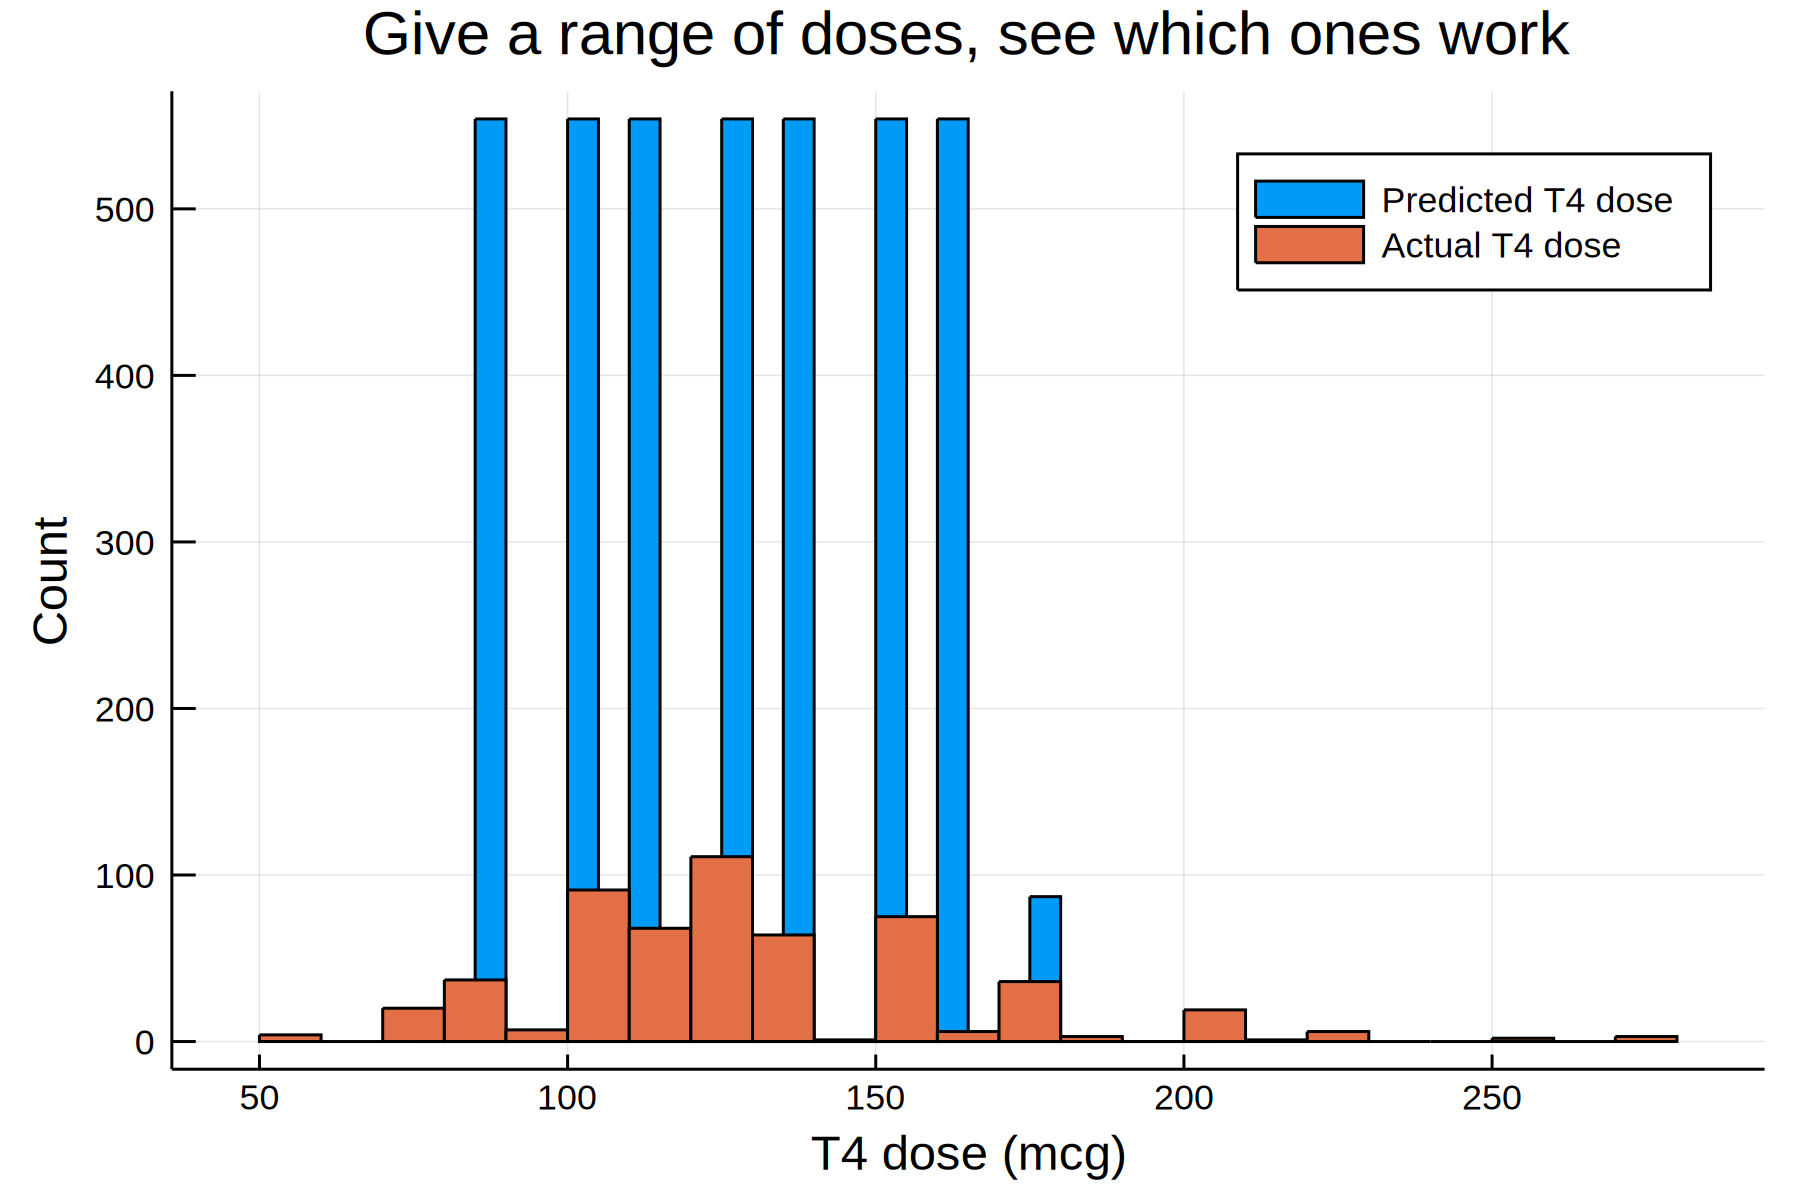

In [131]:
all_together = vcat(result...)
range_doses = histogram(all_together, bin=30, label="Predicted T4 dose", dpi=300,
    xlabel="T4 dose (mcg)", ylabel="Count", title="Give a range of doses, see which ones work")
histogram!(range_doses, euthy_dose, bin=30, label="Actual T4 dose")

In [132]:
savefig(range_doses, "schneider_dosage_prediction.svg")